# EXPERIMENT 1 : AHP

<ol>
<li> Continuation from  <b> 9th_Exp_11.6K_100epoch_zoomix </b> </li>
<li> No Augmentation </li>
<li> dice_coef </li>
</ol>


In [1]:
import os
#import cv2
import numpy as np
import tensorflow as tf
import random
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras as K
from tensorflow.python.util.tf_export import tf_export
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.data import AUTOTUNE
from tensorflow.keras.layers.experimental import preprocessing
from modules.keras_models import MobileNetV3SmallSegmentation
from tensorflow.image import ResizeMethod

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#tf.test.is_gpu_available(  cuda_only=False, min_cuda_compute_capability=None)


import logging
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)

import matplotlib.pyplot as plt
%matplotlib inline


# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

#tf.config.run_functions_eagerly(True)

np.random.seed(1337)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [2]:
normalizer = preprocessing.Normalization()

def load_images(imagePath, labelPath):
    # read the image from disk, decode it, convert the data type to
    # floating point, and resize it
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, (224, 224))

    #image = tf.image.per_image_standardization(image)
    
    label = tf.io.read_file(labelPath)
    label = tf.image.decode_png(label, channels=3)
    label = tf.image.rgb_to_grayscale(label)
    label = tf.image.convert_image_dtype(label, dtype=tf.float32)
    #label = tf.image.per_image_standardization(label)
    label = tf.image.resize(label, (224, 224))

    # return the image and the label
    return (image, label)

def augment_using_ops(images, labels):
    images = tf.image.random_brightness(images, 0.2)
    images = tf.image.random_contrast(images, 0.5, 2.0)
    images = tf.image.random_saturation(images, 0.75, 1.25)
    images = tf.image.random_hue(images, 0.1)
    return (images, labels)

In [3]:
#PATH = "Z://AIVie//Patent//siamese-contrastive-pyimage//experiment//Foreground//Semantic-segmentation-with-MobileNetV3//Semantic_Segmn_Master//CVC-612//"
#PATH = "dataset//"
#PATH = "Z://AIVie//Patent//siamese-contrastive-pyimage//experiment//Foreground//dataset//AHP//train//"
#PATH =  "Z://AIVie//Patent//siamese-contrastive-pyimage//experiment//Foreground//dataset//surveil//indoorDataset//indoorDataset//"
PATH =  r"C:\Users\alext\Desktop\dataset\AHP"
CLASS_NUM = 1
SMOOTH = 1e-15
INIT_LR = 1e-2
#TEST_SPLIT = 0.05
VAL_SPLIT = 0.2
IMAGE_SIZE = 224
EPOCHS = 100
BATCH = 32

#images = sorted(glob(os.path.join(PATH, "imageDataset//train/*")))
#masks = sorted(glob(os.path.join(PATH, "pixelLabelDataset//train/*")))

#images = sorted(glob(os.path.join(PATH, "JPEGImages/*")))
#masks = sorted(glob(os.path.join(PATH, "Annotations/*")))

images = sorted(glob(os.path.join(PATH, "AHP3k/*")))
masks = sorted(glob(os.path.join(PATH, "AHP3kMasking/*")))

TOTAL_SIZE = len(images)
VALID_SIZE = int(VAL_SPLIT * TOTAL_SIZE)
#TEST_SIZE = int(TEST_SPLIT * TOTAL_SIZE)

In [4]:
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + SMOOTH) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + SMOOTH)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

#def MeanIOU(y_true, y_pred):

    #m = tf.keras.metrics.MeanIoU(CLASS_NUM)
    #meaniou = m.update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1))
    #return meaniou

    
#def mean_iou(y_true, y_pred):
    
    #y_pred = tf.cast((y_pred > 0.5), tf.int32)
    #score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred, CLASS_NUM)
    #tf.compat.v1.Session().run(tf.compat.v1.local_variables_initializer())
    #with tf.control_dependencies([up_opt]):
        #score = tf.identity(score)
    #return K.mean(K.stack(prec), axis=0)

def IoU_loss(y_true, y_pred):

    numerator = tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred) - numerator 

    jac =  numerator / (denominator + tf.keras.backend.epsilon())

    return 1 - jac

def IoU(y_true, y_pred, t=0.5):


    y_pred_ = tf.cast(y_pred > t, dtype=tf.int32)
    y_true = tf.cast(y_true, dtype=tf.int32)

    TP = tf.math.count_nonzero(y_pred_ * y_true)
    FP = tf.math.count_nonzero(y_pred_ * (y_true - 1))
    FN = tf.math.count_nonzero((y_pred_ - 1) * y_true)

    jac = tf.cond(tf.greater((TP + FP + FN), 0), lambda: TP / (TP + FP + FN),
                  lambda: tf.cast(0.000, dtype='float64'))

    return jac

In [5]:
len(masks)

11671

In [6]:
#split IMAGES data into train and validation set
train_x, valid_x = train_test_split(images, test_size=VALID_SIZE, random_state=42)

#split MASKS data into train and validation set
train_y, valid_y = train_test_split(masks, test_size=VALID_SIZE, random_state=42)


#split IMAGES data into  test set
#train_x, test_x = train_test_split(train_x, test_size=TEST_SIZE, random_state=42)

#split MASKS data into test set
#train_y, test_y = train_test_split(train_y, test_size=TEST_SIZE, random_state=42)

In [7]:
len(train_x)

9337

In [8]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

# build the training dataset and data input pipeline
trainDS = tf.data.Dataset.from_tensor_slices((train_x, train_y))
#trainDS = train_ds.map(lambda x, y: (normalization_layer(x), y))
trainDS = (trainDS
    .map(load_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BATCH)
    .prefetch(AUTOTUNE)
)

#trainDS = trainDS.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))

# build the validation dataset and data input pipeline
valDS = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))
valDS = (valDS
    .map(load_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BATCH)
    .prefetch(AUTOTUNE)
)
#valDS = valDS.map(lambda x, y: (normalization_layer(x), y))

# build the testing dataset and data input pipeline
#testDS = tf.data.Dataset.from_tensor_slices((test_x, test_y))
#testDS = (testDS
    #.map(load_images, num_parallel_calls=AUTOTUNE)
    #.cache()
    #.batch(BATCH)
    #.prefetch(AUTOTUNE)
#)

In [9]:
valDS

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>

In [10]:
model = MobileNetV3SmallSegmentation(alpha=1.0, shape=(224, 224), n_class=CLASS_NUM,
                 avg_pool_kernel=(11, 11), avg_pool_strides=(4, 4),
                 resize_method=ResizeMethod.BILINEAR, backbone='small')

opt = Adam(lr=INIT_LR, clipvalue = 5.0)
#opt = Adam(lr=INIT_LR, clip_norm = 1.0)

#m = tf.keras.metrics.MeanIoU(CLASS_NUM)
metrics = [dice_coef,"accuracy", IoU]
#metrics = [dice_coef, "accuracy"]

model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

#callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4)]

In [11]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
    
if len(valid_x) % BATCH != 0:
    valid_steps += 1

In [12]:
H = model.fit(
    trainDS,
    validation_data=valDS,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
)

Epoch 1/100
292/292 [==============================] - 199s 634ms/step - loss: 0.3209 - dice_coef: 0.6791 - accuracy: 0.7665 - IoU: 0.4965 - val_loss: 0.2985 - val_dice_coef: 0.7016 - val_accuracy: 0.8191 - val_IoU: 0.5255
Epoch 2/100
292/292 [==============================] - 149s 508ms/step - loss: 0.1887 - dice_coef: 0.8113 - accuracy: 0.8722 - IoU: 0.6491 - val_loss: nan - val_dice_coef: nan - val_accuracy: 0.8355 - val_IoU: 0.5648
Epoch 3/100
292/292 [==============================] - 146s 500ms/step - loss: 0.1755 - dice_coef: 0.8245 - accuracy: 0.8793 - IoU: 0.6674 - val_loss: nan - val_dice_coef: nan - val_accuracy: 0.8528 - val_IoU: 0.5754
Epoch 4/100
292/292 [==============================] - 146s 500ms/step - loss: 0.1575 - dice_coef: 0.8425 - accuracy: 0.8883 - IoU: 0.6913 - val_loss: nan - val_dice_coef: nan - val_accuracy: 0.8829 - val_IoU: 0.6778
Epoch 5/100
292/292 [==============================] - 147s 505ms/step - loss: 0.1379 - dice_coef: 0.8621 - accuracy: 0.8980 -

292/292 [==============================] - 145s 495ms/step - loss: 0.0688 - dice_coef: 0.9312 - accuracy: 0.9307 - IoU: 0.8209 - val_loss: 0.0817 - val_dice_coef: 0.9183 - val_accuracy: 0.9257 - val_IoU: 0.8032
Epoch 39/100
292/292 [==============================] - 145s 496ms/step - loss: 0.0641 - dice_coef: 0.9359 - accuracy: 0.9327 - IoU: 0.8283 - val_loss: 0.0877 - val_dice_coef: 0.9123 - val_accuracy: 0.9230 - val_IoU: 0.7897
Epoch 40/100
292/292 [==============================] - 145s 496ms/step - loss: 0.0632 - dice_coef: 0.9368 - accuracy: 0.9331 - IoU: 0.8298 - val_loss: 0.0822 - val_dice_coef: 0.9178 - val_accuracy: 0.9247 - val_IoU: 0.7959
Epoch 41/100
292/292 [==============================] - 145s 495ms/step - loss: 0.0615 - dice_coef: 0.9385 - accuracy: 0.9339 - IoU: 0.8322 - val_loss: 0.0893 - val_dice_coef: 0.9107 - val_accuracy: 0.9219 - val_IoU: 0.7878
Epoch 42/100
292/292 [==============================] - 145s 496ms/step - loss: 0.0643 - dice_coef: 0.9357 - accuracy

Epoch 75/100
292/292 [==============================] - 145s 496ms/step - loss: 0.0574 - dice_coef: 0.9426 - accuracy: 0.9356 - IoU: 0.8384 - val_loss: 0.0742 - val_dice_coef: 0.9258 - val_accuracy: 0.9285 - val_IoU: 0.8089
Epoch 76/100
292/292 [==============================] - 145s 496ms/step - loss: 0.0535 - dice_coef: 0.9465 - accuracy: 0.9373 - IoU: 0.8443 - val_loss: 0.0778 - val_dice_coef: 0.9222 - val_accuracy: 0.9267 - val_IoU: 0.8036
Epoch 77/100
292/292 [==============================] - 145s 496ms/step - loss: 0.0547 - dice_coef: 0.9453 - accuracy: 0.9368 - IoU: 0.8425 - val_loss: 0.0796 - val_dice_coef: 0.9204 - val_accuracy: 0.9254 - val_IoU: 0.7966
Epoch 78/100
292/292 [==============================] - 149s 509ms/step - loss: 0.0546 - dice_coef: 0.9454 - accuracy: 0.9369 - IoU: 0.8426 - val_loss: 0.0883 - val_dice_coef: 0.9117 - val_accuracy: 0.9227 - val_IoU: 0.7906
Epoch 79/100
292/292 [==============================] - 145s 496ms/step - loss: 0.0561 - dice_coef: 0.94

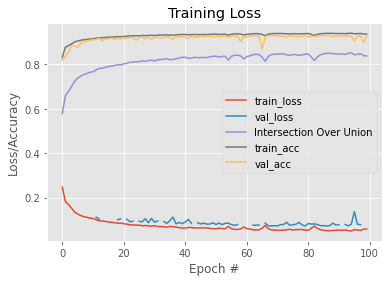

In [13]:
# determine the number of epochs and then construct the plot title
title = "Training Loss"

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["IoU"], label="Intersection Over Union")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title(title)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [14]:
test_steps = (len(valid_x)//BATCH)

if len(valid_x) % BATCH != 0:
    test_steps += 1

model.evaluate(valDS, steps=test_steps)

73/73 [==============================] - 10s 139ms/step - loss: 0.0759 - dice_coef: 0.9241 - accuracy: 0.9274 - IoU: 0.8025


[0.07588283717632294,
 0.9241166710853577,
 0.9274172782897949,
 0.8024625182151794]

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [16]:
# Save the model.
with open('AHP_Original_3905_Images_with_dicecoef&ZoomImg.tflite', 'wb') as f:
    f.write(tflite_model)

In [17]:
def read_test_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_test_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    #x = x/255.0
    return x

def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [18]:
# import cv2
# for i, (x, y) in enumerate(zip(valid_x[:390], valid_y[:390])):
#     x = read_test_image(x)
#     y = read_test_mask(y)
#     y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
#     h, w, _ = x.shape
#     white_line = np.ones((h, 10, 3))

#     all_images = [
#         x, white_line,
#         mask_parse(y), white_line,
#         mask_parse(y_pred)
#     ]
#     image = np.concatenate(all_images, axis=1)
    
#     fig = plt.figure(figsize=(12, 12))
#     a = fig.add_subplot(1, 1, 1)
#     imgplot = plt.imshow(image)

In [19]:
#model.save("C:\Users\alext\Desktop\AHP\model")